In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the CSV file
file_path = 'df.csv'
data = pd.read_csv(file_path)
fee_rate = 0.0005

df = data.drop(
    columns=['Unnamed: 0', 'poolDayDatas_date', 'poolDayDatas_sqrtPrice', 'poolDayDatas_tick',
             'date.1', 'date', 'poolDayDatas_volumeToken0', 'poolDayDatas_volumeToken1'], axis=1
)
df.columns = ['volumeUSD', 'liquidity', 'avgGasPrice']
df = df.dropna()
# define types as float
df = df.astype(float)
# data_cleaned['fees'] = data_cleaned['volumeUSD'] * fee_rate

In [3]:
df['volumeUSD_norm'] = (df['volumeUSD'] - df['volumeUSD'].min()) / (df['volumeUSD'].max() - df['volumeUSD'].min())
df['liquidity_norm'] = (df['liquidity'] - df['liquidity'].min()) / (df['liquidity'].max() - df['liquidity'].min())
df['avgGasPrice_norm'] = (df['avgGasPrice'] - df['avgGasPrice'].min()) / (df['avgGasPrice'].max() - df['avgGasPrice'].min())

# Calculate the dynamic fee based on the normalized values
# We'll use a simple average of the normalized values to determine the fee
df['dynamic_fee'] = (df['volumeUSD_norm'] + df['liquidity_norm'] + df['avgGasPrice_norm']) / 3

# Scale the fee to the range (0, 0.01]
df['dynamic_fee'] = df['dynamic_fee'] * 0.01

# Ensure the fee is within the range (0, 0.01]
df['dynamic_fee'] = df['dynamic_fee'].clip(upper=0.01)

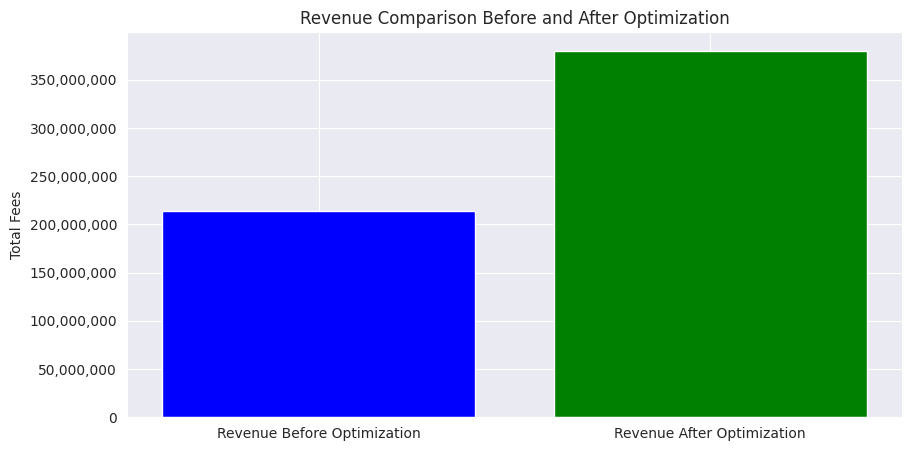

In [5]:
df['revenue'] = df['volumeUSD'] * fee_rate
df['dynamic_revenue'] = df['volumeUSD'] * df['dynamic_fee']
# Summing up the total revenues
total_static_revenue = df['revenue'].sum()
total_dynamic_revenue = df['dynamic_revenue'].sum()

# Labels and revenue values for plotting
labels = ['Revenue Before Optimization', 'Revenue After Optimization']
revenue_values = [total_static_revenue, total_dynamic_revenue]

# Plotting revenue comparison
plt.figure(figsize=(10, 5))
plt.bar(labels, revenue_values, color=['blue', 'green'])
plt.ylabel('Total Fees')
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Revenue Comparison Before and After Optimization')
plt.show()

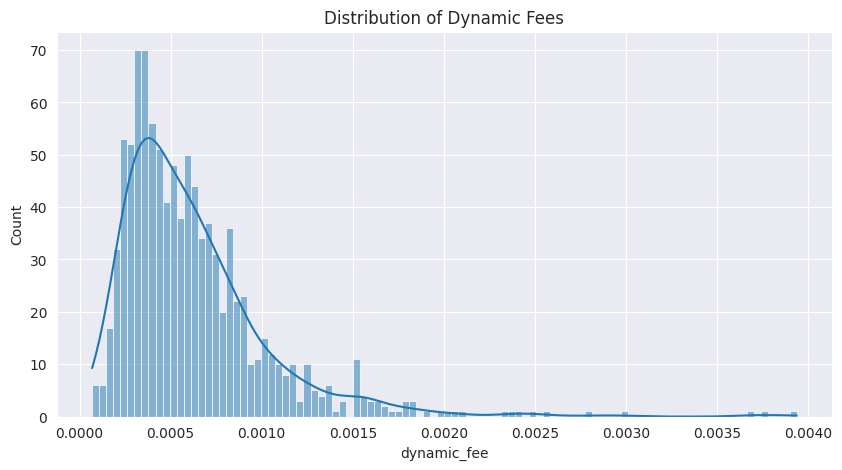

In [6]:
# bin plot for dynamic fees
plt.figure(figsize=(10, 5))
sns.histplot(df['dynamic_fee'], bins=100, kde=True)
plt.title('Distribution of Dynamic Fees')
plt.show()